<img style="float: left;" src="Perm.png" width="30%">   

# <font color='Red'> $\;$ Reservoir model for geothermal doublet</font>

## <font color='Blue'>Introduction</font>
###  In this exercise, we run simulation in a 3D channelized reservoir.

## <font color='blue'>The objectives:</font>
1. Introduce custom <font color='red'>'Model'</font> class based on 
 * Class [DartsModel](darts/models/darts_model.py) with base model capabilities
 * Class [StructReservoir](darts/models/reservoirs/struct_reservoir.py) with structured reservoir
 * Class [GeothermalPhysics](darts/models/physics/geothermal.py) for geothermal engine is used
 * Class [Properties](darts/models/physics/iapws/iapws_property.py) for geothermal fluid based on IAPWS-97 Equatipn of State.
2. Use run_python procedure to control run from the python script
3. Introduce wells and change their location

## <font color='Blue'>Let's start!</font>


In [8]:
from darts.models.reservoirs.struct_reservoir import StructReservoir
from darts.models.physics.geothermal import Geothermal
from darts.models.darts_model import DartsModel
from darts.models.physics.iapws.iapws_property_vec import _Backward1_T_Ph_vec
from darts.tools.keyword_file_tools import load_single_keyword
from darts.engines import redirect_darts_output
import numpy as np
redirect_darts_output('run.log')

#### Brief Introduction of model inheritance
* Here create the <font color='red'>'Model' </font>  class, which inherits from <font color='red'>DartsModel</font> (the base class).
* It keeps all the functionalities of <font color='red'>DartsModel</font> and can also be extended to add more functionalities.
* If a function is redefined in subclass, the function in base class with identical name will be overridden.

In [9]:
class Model(DartsModel):
    def __init__(self, n_points=128):
        # call base class constructor
        super().__init__()
        
        self.timer.node["initialization"].start()
        
        # parameters for the reservoir
        self.name = 'base'        
        (nx, ny, nz) = (60, 60, 7)
        nb   = nx * ny * nz
        perm = np.ones(nb) * 1000
        #perm = load_single_keyword('perm.in', 'PERMX')
        
        poro = np.ones(nb) * 0.2
        dz   = np.ones(nb) * 15
        
        # adjust for over/under-burden
        perm[:nx*ny]  = 1e-5
        perm[-nx*ny:] = 1e-5
        poro[:nx*ny]  = 1e-5
        poro[-nx*ny:] = 1e-5 
        
        # discretize structured reservoir
        self.reservoir = StructReservoir(self.timer, nx=nx, ny=ny, nz=nz, dx=30, dy=30, dz=dz, permx=perm,
                                         permy=perm, permz=perm*0.1, poro=poro, depth=2000)
        
        # add open boundaries
        self.reservoir.set_boundary_volume(xz_minus=1e8, xz_plus=1e8, yz_minus=1e8, yz_plus=1e8)
        
        # add well's locations
        self.iw = [30, 30]
        self.jw = [14, 46]
        
        # add well
        self.reservoir.add_well("INJ")
        n_perf = self.reservoir.nz        
        # add perforations to te payzone
        for n in range(1, n_perf-1):
            self.reservoir.add_perforation(well=self.reservoir.wells[-1], i=self.iw[0], j=self.jw[0], k=n+1, 
                                           well_radius=0.16)

        # add well
        self.reservoir.add_well("PRD")
        # add perforations to te payzone        
        for n in range(1, n_perf-1):
            self.reservoir.add_perforation(self.reservoir.wells[-1], self.iw[1], self.jw[1], n+1, 0.16)

        # rock heat capacity and rock thermal conduction
        hcap = np.array(self.reservoir.mesh.heat_capacity, copy=False)
        rcond = np.array(self.reservoir.mesh.rock_cond, copy=False)
        hcap.fill(2200)
        rcond.fill(500)

        # create physics for geothermal
        self.physics = Geothermal(self.timer, n_points, 1, 351, 1000, 10000, cache=False)

        # timestep parameters
        self.params.first_ts = 1e-3
        self.params.mult_ts  = 2
        self.params.max_ts   = 365

        # nonlinear and linear solver tolerance
        self.params.tolerance_newton = 1e-2
        self.params.tolerance_linear = 1e-4

        self.timer.node["initialization"].stop()

    def set_initial_conditions(self):
        self.physics.set_uniform_initial_conditions(self.reservoir.mesh, uniform_pressure=200,
                                                    uniform_temperature=350)

    def set_boundary_conditions(self):
        for i, w in enumerate(self.reservoir.wells):
            if i == 0:
                w.control = self.physics.new_rate_water_inj(6000, 300)
            else:
                w.control = self.physics.new_rate_water_prod(6000)
                
    def export_pro_vtk(self, file_name='Results'):
        X = np.array(self.physics.engine.X, copy=False)
        nb = self.reservoir.mesh.n_res_blocks
        temp = _Backward1_T_Ph_vec(X[0:2 * nb:2] / 10, X[1:2 * nb:2] / 18.015)
        local_cell_data = {'Temperature': temp,
                           'Perm': self.reservoir.global_data['permx']}
        self.export_vtk(file_name, local_cell_data=local_cell_data)

<img style="float: left;" src="slides/Slide4.PNG" width="80%">

In [10]:
m = Model()
m.init()
m.run_python(0.001)
m.export_pro_vtk(m.name)


darts-package built on 09/09/2022 17:24:20 by dvoskov@TUD261133 from c029c02-dirty
Reading PERMX from C:\Users\dvoskov\surfdrive\Teaching\AESM2305\2022\Notebooks\perm.in... 25200 values have been read.
Building connection list...
Applying ACTNUM...
Inactive blocks due to ACTNUM:  0
Inactive connections due to transmissibility:  0
Inactive connections total:  0
Inactive blocks due to inactive connections:  0
# 1 	T = 0.001	DT = 0.001	NI = 5	LI=14
TS = 1(0), NI = 5(0), LI = 14(0)
Interpolating missing data in DX...
Interpolating missing data in DY...
# 1 	T = 365.001	DT = 365	NI = 6	LI=46
TS = 2(0), NI = 11(0), LI = 60(0)


<img style="float: left;" src="slides/Slide5.PNG" width="80%">

In [11]:
import pandas as pd
td = pd.DataFrame.from_dict(m.physics.engine.time_data)


In [12]:
import matplotlib.pyplot as plt
string = 'PRD : temperature'


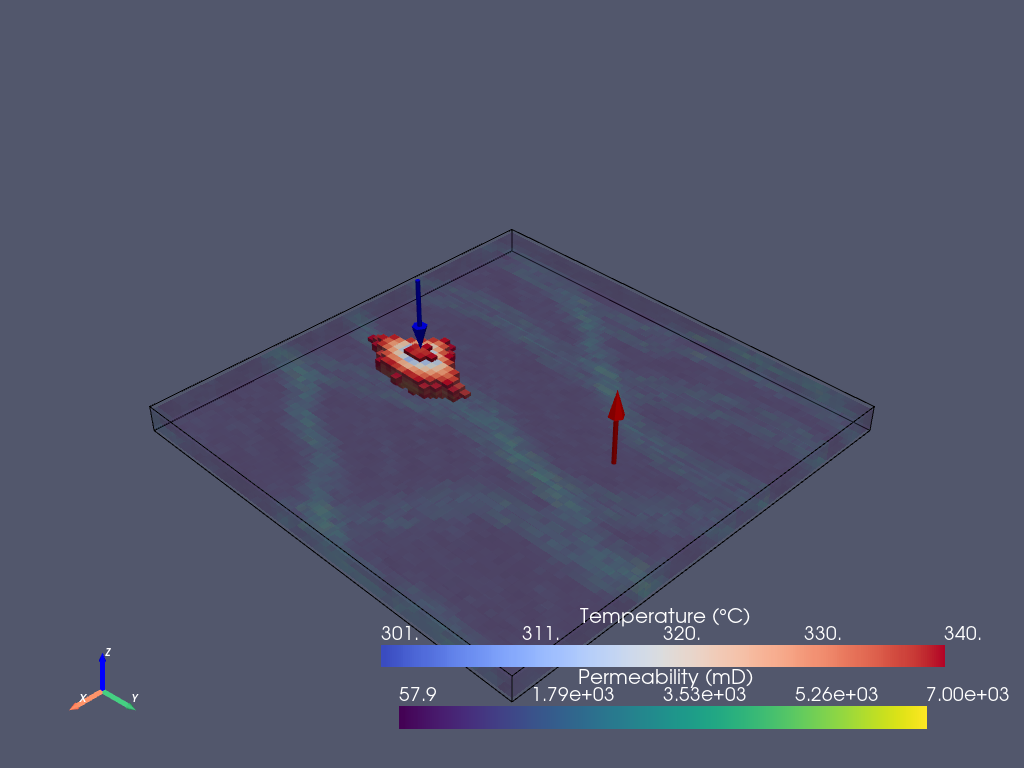

In [13]:
import pyvista as pv

# get vts data
mesh = pv.read('vtk_data/' + m.name + '_ts3.vts')

# define plotter
plotter = pv.Plotter()

# set temperature as active scalar
mesh.set_active_scalars('Temperature')
# add threshold levels
threshed = mesh.threshold([300, 340], invert=False)

# set temperature as active scalar
mesh.set_active_scalars('Perm')
# add threshold levels
perm = mesh.threshold([1, 7e3], invert=False)

# add outline of mesh
outline = mesh.outline()

# add elements to plotter
plotter.set_background('#52576c')
plotter.add_mesh(outline, color='k')
plotter.add_mesh(perm, cmap='viridis',
                 opacity=0.15,
                 stitle='Permeability (mD)')

plotter.add_mesh(threshed, cmap='coolwarm',
                 stitle='Temperature (\N{DEGREE SIGN}C)')

# add wells as arrows
inj = np.array([m.iw[0]*30-15, m.jw[0]*30-15, -1700])
prod = np.array([m.iw[1]*30-15, m.jw[1]*30-15, -2000])

injdir = np.array([0,0,-100])
proddir = np.array([0,0,100])

_ = plotter.add_arrows(inj, injdir, mag=3, color='b')
_ = plotter.add_arrows(prod, proddir, mag=3, color='r')
_ = plotter.add_axes(line_width=5, labels_off=False)

plotter.show()